In [1]:
import glob
import os
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import ascii
from astropy.table import Table

plt.rcParams['figure.facecolor']    = 'white'
import pandas as pd    
from datetime import date
today=date.today()
DATE =today.strftime("%m_%d_%y")
print(DATE)
import glob
from astropy.coordinates import SkyCoord, EarthLocation
import astropy.units as u

vlt = EarthLocation.of_site('paranal')  # the easiest way... but requires internet


# from utils import *

07_17_25


In [2]:
files_113 = glob.glob('../data/p113_data/*.fits')
files_112 = glob.glob('../data/p112_data/*.fits')
li_line = 6707.926


In [3]:
def get_files(files):
    obj_dir = {}
    c=3e5 #km/s

    for i,file in enumerate(files):
        with fits.open(file) as hdul:
            hdul = fits.open(file)
            header  = hdul[0].header
            #print(header.cards['HIERARCH ESO QC CCF RV ERROR'])
            data    = hdul[1].data
            time    = header['HIERARCH ESO QC BJD']
            name    = header['OBJECT']
            obj     = int(header['HIERARCH ESO OBS NAME'].split('-')[0][2:])
            grade   = header['OB_GRADE'].replace(" ", "")
            if grade =='C':
                print('RG',obj,header['OB_GRADE'])
                continue

            ra,dec  = header['RA'], header['DEC']
            obs_T   = header['DATE-OBS'].split('T')[0]
            rv_val  =  header['HIERARCH ESO QC CCF RV']#header['HIERARCH ESO OCS OBJ RV'] #km/s
            rv_err  = header['HIERARCH ESO QC CCF RV ERROR'] #km/s
            sc = SkyCoord(ra=ra*u.deg, dec=dec*u.deg)
            rv_corr = rv_val
            err_corr = rv_err
            if name=='UCAC4 308-077592':
                if obj in obj_dir.keys():
                    obj_dir[obj]['file'].append(file)
                    obj_dir[obj]['rv'].append(rv_corr)
                    obj_dir[obj]['time'].append(time)
                    obj_dir[obj]['err'].append(err_corr)
                    obj_dir[obj]['name'].append(name)
                    obj_dir[obj]['grade'].append(grade)
                else:
                    obj_dir[obj] = {'file': [file], 'rv': [rv_corr], 
                                    'time': [time], 'err': [err_corr], 
                                    'name': [name], 'grade': [grade]}
            else:
                if rv_corr >= -100:
                    if obj in obj_dir.keys():
                        obj_dir[obj]['file'].append(file)
                        obj_dir[obj]['rv'].append(rv_corr)
                        obj_dir[obj]['time'].append(time)
                        obj_dir[obj]['err'].append(err_corr)
                        obj_dir[obj]['name'].append(name)
                        obj_dir[obj]['grade'].append(grade)
                    else:
                        obj_dir[obj] = {'file': [file], 'rv': [rv_corr], 
                                        'time': [time], 'err': [err_corr], 
                                        'name': [name], 'grade': [grade]}
    print(len(obj_dir.keys()))   
    targets_to_remove = []
    for k, v in obj_dir.items():
        if len(v['time']) < 3:
            targets_to_remove.append(k)
    for i in range(len(targets_to_remove)):
        del obj_dir[targets_to_remove[i]]
    print(len(obj_dir.keys()))

    myKeys = list(obj_dir.keys())
    myKeys.sort()
    obj_dir = {i: obj_dir[i] for i in myKeys}
    return obj_dir
obj_dir_112 = get_files(files_112)
obj_dir_113 = get_files(files_113)

RG 20 C
RG 13 C
RG 14 C
RG 1 C
19
10
RG 12 C
RG 6 C
RG 3 C
RG 11 C
RG 22 C
RG 15 C
RG 3 C
RG 8 C
RG 3 C
RG 25 C
RG 8 C
RG 22 C
RG 3 C
RG 7 C
RG 23 C
25
25


In [4]:
def rv_correct(rg, obj_dir, lower_wave, plot=False):
    c = 3e5 #km/s
    files = obj_dir[rg]['file']
    rvs    = obj_dir[rg]['rv']
    plt.figure(figsize=(15,10))

    all_flux = []
    all_wave = []
    all_ferr = [] #flux_err
    for i,file in enumerate(files):
        with fits.open(file) as hdul:
            hdul = fits.open(file)
            header = hdul[0].header
            data  = hdul[1].data
            rv_val  =  header['HIERARCH ESO QC CCF RV']#header['HIERARCH ESO OCS OBJ RV'] #km/s
            wave, flux = data['WAVE_AIR'][0], data['FLUX    '][0]
            flux_err   = data['ERR'][0]
            mask       = (wave > lower_wave)
            wave, flux = wave[mask], flux[mask]
            flux_err   = flux_err[mask]
            plt.subplot(len(files),1,i+1)
            plt.plot(wave, flux, lw=0.5)
            plt.axvline(li_line,c='C1')
            plt.xlim(6700, 6717)
            mask = (wave >= 6708) & (wave <= 6710)
            new_wave = wave[mask]
            new_flux = flux[mask]
            w0 = li_line*1
            w1 = new_wave[np.argmin(new_flux)]
            shift = (rv_val/c)*(w0)
            #print((w1 - w0)*c/w0, rv_val, shift)
            plt.plot(wave-shift, flux)
            
            corrected_wave = wave-shift
            all_wave.append(corrected_wave)
            all_flux.append(flux)
            all_ferr.append(flux_err)      
    plt.tight_layout()
    if not plot: plt.close()
    return all_wave, all_flux, all_ferr
    
_,_,_ = rv_correct(1, obj_dir_112, lower_wave=4500.)



In [5]:
def interp_wave(w, f, fe):
    '''
    interpolate all the wavelength to same grid for target spectrum
    @input:
        w : original wavelength grid of each observation after RV correction
        f : flux values of each observation
    '''
    
    wave_grid = w[0]

    all_flux = []
    all_flux.append(f[0])
    
    all_ferr = []
    all_ferr.append(fe[0])
    
    for i in range(1,len(w)):
        target_wave, target_flux, target_ferr = w[i],f[i],fe[i]
        target_flux_interp = np.interp(wave_grid, target_wave, target_flux)
        target_ferr_interp = np.interp(wave_grid, target_wave, target_ferr)
        all_flux.append(target_flux_interp)
        all_ferr.append(target_ferr_interp)
       
    return wave_grid, all_flux, all_ferr

    

In [6]:
def stack(all_flux,plot=False):
    stacked = np.sum(np.array(all_flux), axis=0)
    if plot:# plot stacked spectra
        plt.figure(figsize=(10,4))

        for spectrum in all_flux:
            plt.plot(w,spectrum)

        plt.plot(w,stacked,label='stacked')
        plt.legend()
        plt.xlim(6550,6570)
        plt.ylim(0,0.4e-12)

        plt.tight_layout()
    return stacked


In [7]:
def load_template(RG, program):
    
    table4 = pd.read_csv('table4.csv')
    rv_df = pd.read_csv('comb_rvs.csv')
    vbroad = rv_df[(rv_df.program==program) & (rv_df.RG_id==RG)].vbroad.values[0]

    templates = glob.glob('../files/Arcturus_templates/arcturus_*.txt')
    fname = '../files/Arcturus_templates/arcturus_vsini_%s.txt'%vbroad
    
    print(vbroad, fname)    
    
    template_og = pd.read_csv(fname,delimiter=' ')
    return template_og


In [8]:
def interp_template(wave_grid, template,plot=False):
    
    min_wave_esp, max_wave_esp = min(wave_grid), max(wave_grid)
    
    template = template[(template.waveobs <= max_wave_esp) & (template.waveobs >= min_wave_esp)]
    temp_wave = np.array(template.waveobs)
    temp_flux = np.array(template.flux)
    temp_flux_interp = np.interp(wave_grid, temp_wave, temp_flux)

    print('N points in target spectrum:',len(wave_grid))
    print('N points in template spectrum:',len(temp_wave))
    if plot:
        plt.figure(figsize=(10,4),dpi=200)

        plt.plot(temp_wave, temp_flux, label='OG template')
        plt.plot(wave_grid, temp_flux_interp, label='interpolate template')
        plt.xlim(6550,6570)
        plt.ylim(0.5,1.1)
    return temp_flux_interp


In [9]:
def id_cont(wave, flux, percentage=5):
    '''
    identify continuum
    percentage of spectra to mask out; default is 5%
    '''
    percentage /= 100
    lower, upper = 1-percentage,1+percentage,
    mask = (flux<=upper) & (flux>=lower)
    return mask
    
def fit_cont(wave, flux, order=3):
    '''
    fit the continuum with polynomial
    '''
    coefficients  = np.polyfit(wave, flux, order) # Fit a n-order polynomial
    poly_function = np.poly1d(coefficients)
    fitted_flux   = poly_function(wave)
    return poly_function
    

In [10]:
plt.rcParams['figure.facecolor'] = 'white'


13.34 ../files/Arcturus_templates/arcturus_vsini_13.34.txt
N points in target spectrum: 337280
N points in template spectrum: 453674


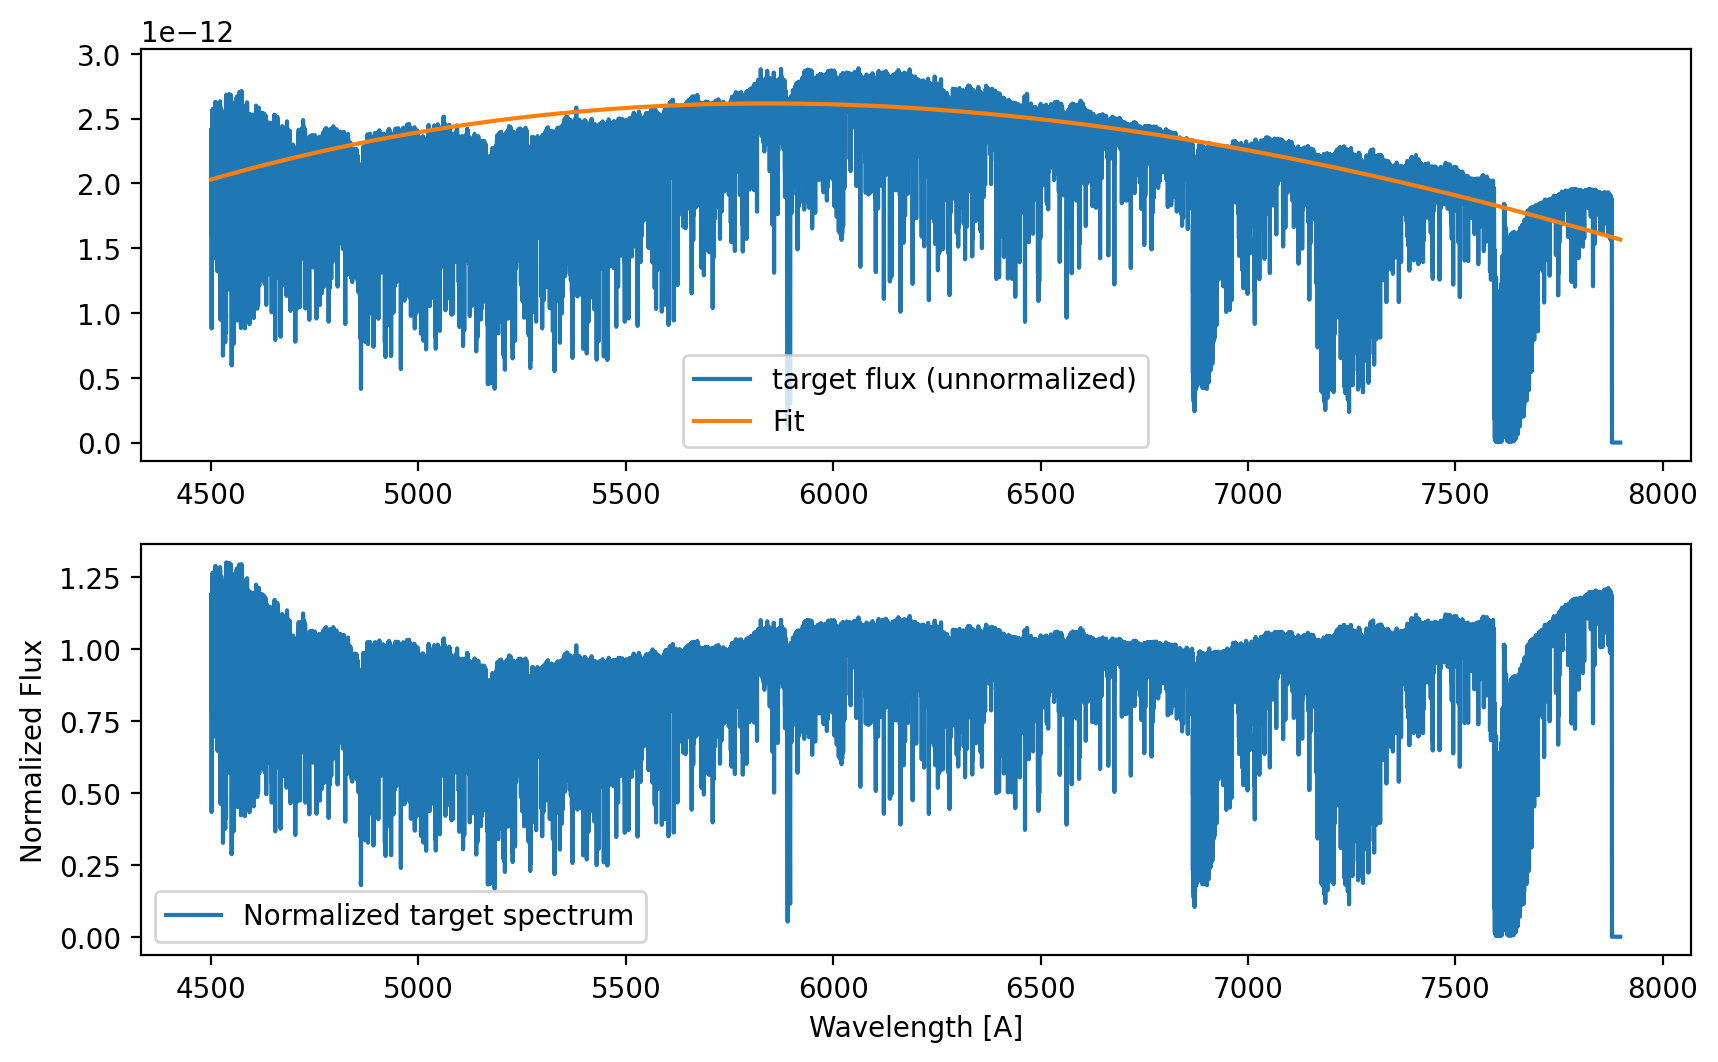

In [51]:
def pipeline(RG, obj_dir, program, lower_wave, percentage=5, close=False, savefig=False, savetxt=False):
    
    # load RV corrected spectra
    wave, flux, ferr      = rv_correct(RG, obj_dir, lower_wave)
    
    # interpolate RV corrected spectra onto one grid
    wave_grid, flux, ferr = interp_wave(wave, flux, ferr)
    
    # stack all target spectrum
    stacked_flux     = stack(flux,plot=False)
    avg_ferr         = np.mean(ferr, axis=0)
    
    target_flux      = stacked_flux*1

    # load template based on each target's vbroad
    template         = load_template(RG, program)
    
    # interpolate the template onto target spectrum grid
    temp_flux_interp = interp_template(wave_grid, template)           
    
    # identify the continuum in the template
    cont_mask        = id_cont(wave_grid, temp_flux_interp, percentage) 
    
#     plt.figure(figsize=(10,4),dpi=200)
#     plt.plot(wave_grid, temp_flux_interp)
#     plt.plot(wave_grid[cont_mask], temp_flux_interp[cont_mask])
#     plt.xlim(6550,6570)
    if close: plt.close()

    # mask out the continuum indices in the target spectrum
    cont_wave, cont_flux = wave_grid[cont_mask], target_flux[cont_mask]
    
    fig = plt.figure(figsize=(10,6),dpi=200)
    ax1 = plt.subplot(211)
    plt.plot(wave_grid, target_flux, label='target flux (unnormalized)')
#     plt.plot(cont_wave, cont_flux, label='continuum identified (unnormalized)')
#     plt.show()
#     plt.xlim(6550,6570)
    
    # fit a polynomial to the continuum in the target spectrum
    poly_func = fit_cont(cont_wave, cont_flux)
    plt.plot(wave_grid, poly_func(wave_grid) , label='Fit')
    plt.legend()
    # divide the original target flux values by the function
    target_flux_norm = stacked_flux/poly_func(wave_grid) 
    
    
    ax2 = plt.subplot(212)
    plt.plot(wave_grid, target_flux_norm, label='Normalized target spectrum')
#     plt.plot(wave_grid, temp_flux_interp, label='Arcturus template interpolated')
    plt.xlabel('Wavelength [A]')
    plt.ylabel('Normalized Flux')
    plt.legend()
    
#     ax3 = plt.subplot(413)
#     plt.plot(wave_grid, target_flux_norm, label='Normalized target spectrum')
#     plt.plot(wave_grid, temp_flux_interp, label='Arcturus template interpolated')
#     plt.legend()
#     plt.title('H-alpha line')
#     plt.xlim(6550,6570)
#     plt.ylim(0.,1.2)
    
#     ax4 = plt.subplot(414)
#     plt.plot(wave_grid, target_flux_norm, label='Normalized target spectrum')
#     plt.plot(wave_grid, temp_flux_interp, label='Arcturus template interpolated')
#     plt.legend()
#     plt.title('Li line')
#     plt.xlim(6700, 6710)
#     plt.ylim(0.,1.2)

#     rv_df = pd.read_csv('comb_rvs.csv')
#     rv_df = rv_df[(rv_df.program==program) & (rv_df.RG_id==RG)]
#     Li_val = rv_df.Li_val.values[0]
#     vbroad = rv_df.vbroad.values[0]
    
#     title = 'P%s RG%s:    Li = %.1f    vbroad = %.1f' % (program, RG, Li_val, vbroad)
#     ax1.set_title(title)

#     plt.tight_layout()
#     if savefig: plt.savefig('../files/normalized_spectra_png/%s_%s.png'%(program, RG),bbox_inches='tight',dpi=200)
#     if close: plt.close()
    
#     print(len(wave_grid),len(ferr))
    
#     spectrum = np.array([wave_grid, target_flux_norm, avg_ferr]).T
#     savedir  = '../files/normalized_spectra_txt/'
#     fname    = savedir+'%s_%s.txt'%(program, RG)
#     print(fname)
#     ax1.set_xlim(6980,6985)
#     if savetxt: np.savetxt(fname,spectrum)
    plt.savefig('../plots/check_cosmic_rays/%s_%s.png'%(program, RG),bbox_inches='tight',dpi=200)

# for i,RG in enumerate(obj_dir_112.keys()):
#     pipeline(RG,obj_dir_112,112,lower_wave=4500.,close=False,savefig=False,savetxt=False)
        
pipeline(23,obj_dir_112,112,lower_wave=4500.,close=False,savefig=False,savetxt=False)


In [67]:
import urllib.request

def download_spectra(sobject_id,ccd):
    """
    Try to download the specfici spectrum from Datacentral
    """
    print('Trying to download '+str(sobject_id)+str(ccd)+'.fits from')
#     print('https://cloud.datacentral.org.au/apps/files/?dir=/GALAH/DR3/data/galah/dr3/spectra/'+str(sobject_id)+str(ccd)+'.fits')
#     url          = 'https://cloud.datacentral.org.au/apps/files/?dir=/GALAH/DR3/data/galah/dr3/spectra/'+str(sobject_id)+str(ccd)+'.fits'
    output_fname = '../files/galah_spectra/'+str(sobject_id)+str(ccd)+'.fits'
#     print(url)
    url = 'https://datacentral.org.au/vo/slink/links?ID=170514002101318&DR=galah_dr3&IDX=0&FILT=R&RESPONSEFORMAT=fits'

    urllib.request.urlretrieve(url, output_fname)
    return [output_fname]

In [68]:
download_spectra(170514002101318,3)

Trying to download 1705140021013183.fits from


URLError: <urlopen error [SSL: WRONG_VERSION_NUMBER] wrong version number (_ssl.c:1129)>

In [69]:
def compare_to_galah(program, RG):
    savedir  = '../files/normalized_spectra_txt/'
    fname    = savedir+'%s_%s.txt'%(program, RG)
    table4   = pd.read_csv('table4.csv')
#     rv_df    = pd.read_csv('comb_rvs.csv')
    sobject_id = table4[(table4.program==program) & (table4.RG_id==RG)].sobject_id.values[0]
#     print(sobject_id)
    return table4.sobject_id.tolist()
    
compare_to_galah(112,23)

[161104004801189,
 150829004301285,
 160129003601260,
 190212001601338,
 170514002101318,
 140806001701013,
 170602003701360,
 170416004301008,
 160521004801082,
 140707003101315,
 170509005201208,
 170418005701333,
 170801002501304,
 170615003401088,
 160327006601149,
 160524006101130]

In [12]:
ss

NameError: name 'ss' is not defined

In [ ]:
for i,RG in enumerate(obj_dir_113.keys()):
    pipeline(RG,obj_dir_113,113,close=False,savefig=False,savetxt=False)
    

In [ ]:
def checking(program, RG):
    data = np.loadtxt('../files/normalized_spectra_txt/%s_%s.txt'%(program, RG))
    wave, flux = data[:,0], data[:,1]
    plt.figure(figsize=(10,4))
    plt.plot(wave, flux, lw=1)
#     plt.xlim(6550,6570)
#     plt.ylim(0.,1.5)
checking(113, 1)

In [ ]:
ss

In [ ]:
for i,RG in enumerate(obj_dir_113.keys()):
    pipeline(RG,obj_dir_113,113,close=False,savefig=False,savetxt=False)
    

In [ ]:
def paper_plot(RG, ax1, ax2, label1, label2, program=113, obj_dir = obj_dir_113):

    from utils import PLOT_PARAMS
    PLOT_PARAMS(LS=12,SIZE=12)
    
    wave, flux, ferr      = rv_correct(RG, obj_dir)
    
    # interpolate RV corrected spectra onto one grid
    wave_grid, flux, ferr = interp_wave(wave, flux, ferr)
    
    # stack all target spectrum
    stacked_flux     = stack(flux,plot=False)
    
    template         = load_template(RG, program)
    
    # interpolate the template onto target spectrum grid
    temp_flux_interp = interp_template(wave_grid, template)  
    
    norm_flux = np.loadtxt('../files/normalized_spectra_txt/%s_%s.txt'%(program, RG))[:,1]
    
    #plt.figure(figsize=(6,5))
    #ax1 = plt.subplot(211)

    # mask out for plotting purposes
    
    mask             = (wave_grid>=6549) & (wave_grid<=6571)
    wave_grid        = wave_grid[mask]
    stacked_flux     = stacked_flux[mask]
    norm_flux        = norm_flux[mask]
    temp_flux_interp = temp_flux_interp[mask]
    
    ax1.plot(wave_grid,stacked_flux,color='grey',lw=0.5,alpha=0.8)
    ax1.set_xlim(6550,6570)
    
    #ax2 = plt.subplot(212,sharex=ax1)
    ax2.set_ylim(0.,1.2)
    ax2.set_xlim(6550,6570)
    ax2.plot(wave_grid, norm_flux, label='Red Giant',color='grey',lw=0.5,alpha=0.8)
    ax2.plot(wave_grid, temp_flux_interp, label='Arcturus Template', color='darkred',lw=1)
    ax2.legend(loc='lower left')
        
    ax1.set_ylabel('Flux')
    ax2.set_ylabel('Normalized Flux')
    ax2.set_xlabel(r'Wavelength [$\AA$]')
    
    rv_df = pd.read_csv('comb_rvs.csv')
    
    Li_val = rv_df[(rv_df.program==program) & (rv_df.RG_id==RG)].Li_val.values[0]
    vbr    = rv_df[(rv_df.program==program) & (rv_df.RG_id==RG)].vbroad.values[0]
    text   = r'A(Li) = %.1f dex, $v_{\rm broad}$ = %.1f km s$^{-1}$' % (Li_val,vbr)
    
    ax1.text(0.97, 0.05, s=label1, transform=ax1.transAxes, ha='right',va='bottom', fontsize=14)
    ax2.text(0.97, 0.05, s=label2, transform=ax2.transAxes, ha='right',va='bottom', fontsize=14)
    
    ax1.text(0.03, 0.05, s=text, transform=ax1.transAxes, ha='left',va='bottom')
    ax1.tick_params(axis='x', labelbottom=False)
    
    if RG == 19:
        ax2.tick_params(axis='x', labelbottom=True)
    else:
        ax2.tick_params(axis='x', labelbottom=False)

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, figsize=(6,12))
paper_plot(20, ax1, ax2, 'A', 'B')
paper_plot(1,  ax3, ax4, 'C', 'D')
paper_plot(19, ax5, ax6, 'E', 'F')

plt.tight_layout()
plt.subplots_adjust(hspace=0)
# plt.savefig('../plots/example_spectra.png',bbox_inches='tight',dpi=200)
plt.show()


In [ ]:
for i,RG in enumerate(obj_dir_113.keys()):
    pipeline(RG,obj_dir_113,113,close=True,savefig=False,savetxt=True)

In [ ]:
for RG in obj_dir_112.keys():
    pipeline(RG,obj_dir_112,112,close=True,savefig=False,savetxt=True)

In [ ]:
plt.plot(w, f)
plt.xlim(4200, 4500)


In [ ]:
ss

In [ ]:
pipeline(21,obj_dir_113,113,close=False)

In [ ]:
pipeline(1,obj_dir_112,112,close=True)

In [ ]:
pipeline(6,obj_dir_112,112)

In [ ]:
ss

## Practice with Catherine

In [ ]:
file = files_113[11]
hdul = fits.open(file)
header     = hdul[0].header
data       = hdul[1].data
rv_val     =  header['HIERARCH ESO QC CCF RV']#header['HIERARCH ESO OCS OBJ RV'] #km/s
wave, flux = data['WAVE_AIR'][0], data['FLUX    '][0]
mask       = (wave > 3800)
wave, flux = wave[mask], flux[mask]

plt.figure(figsize=(12,3),dpi=150)
plt.plot(wave, flux)
plt.title(header['OBJECT'])
#     plt.xlim(6550,6570)
plt.xlim(4850, 4870)
plt.ylim(0,0.6e-13)
plt.show()